In [47]:
# https://towardsdatascience.com/a-comprehensive-guide-to-downloading-stock-prices-in-python-2cd93ff821d4
# https://pypi.org/project/yfinance/
import sys

!{sys.executable} --version
# !{sys.executable} -m pip install yfinance
# !{sys.executable} -m pip install yahoofinancials

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

Python 3.11.5


# get price history

(3696, 10)


Close                High                Low               Open  \
                 F         XOM       F         XOM      F         XOM      F   
Date                                                                           
2024-09-05  10.770  113.169998  11.140  115.279999  10.72  113.070000  11.08   
2024-09-06  10.580  112.639999  10.870  114.180000  10.53  111.730003  10.78   
2024-09-09  10.660  115.010002  10.760  116.150002  10.54  112.660004  10.61   
2024-09-10  10.325  110.995003  10.455  115.400002  10.17  110.169998  10.49   

                          Volume            
                   XOM         F       XOM  
Date                                        
2024-09-05  115.070000  50551900  17200800  
2024-09-06  113.589996  47508900  13467700  
2024-09-09  112.870003  39189700  21644200  
2024-09-10  115.099998  46970729  13252762

<Axes: title={'center': 'Ford stock price'}, xlabel='Date'>

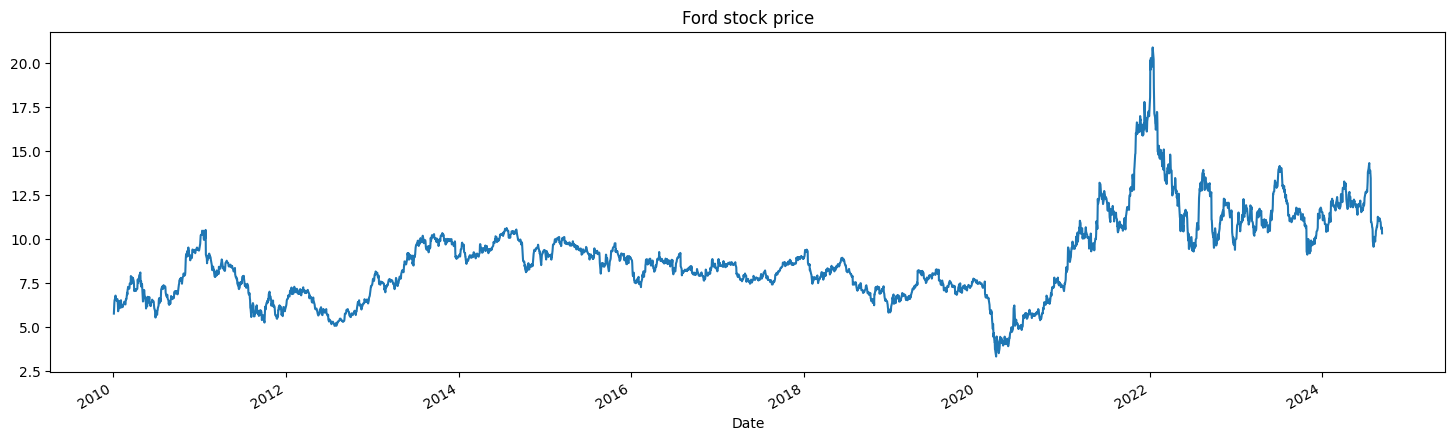

In [48]:
import pickle

prices_df = pickle.load(open("prices.pkl",'rb'))

print(prices_df.shape)
display(prices_df[-4:])

plt.figure(figsize=(18,5))
prices_df[('Close','F')].plot(title="Ford stock price")

# calculate daily returns

In [49]:
from math import log

prices_f = prices_df[[('Close','F')]].squeeze()   # convert from dataframe to series
returns_f = prices_f.apply(log).diff()[1:]        # compute first order differences in the log prices = daily return
print(type(returns_f))
returns_f

<class 'pandas.core.series.Series'>


Date
2010-01-05    0.064052
2010-01-06    0.036726
2010-01-07    0.025186
2010-01-08    0.002570
2010-01-11    0.035297
                ...   
2024-09-04   -0.002736
2024-09-05   -0.016575
2024-09-06   -0.017799
2024-09-09    0.007533
2024-09-10   -0.031930
Name: (Close, F), Length: 3695, dtype: float64

# Moving average
using https://numpy.org/doc/stable/reference/generated/numpy.convolve.html

### np.convolve(x, y) = $\sum{x_t, y_i}$ 
### if length of x > length of y, then use a sliding window over x of the length of y

### for a moving average for w days of prices, y = vector of values of 1/w

In [50]:
import numpy as np

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def moving_sum(x, w):
    return moving_average(x, w) * w


In [51]:
MA_lengths = [14,30,60]
max_length = max(MA_lengths) - 1

MA = pd.DataFrame(np.array(prices_f)[max_length:],columns=['price'])
MA.index = prices_f.index[-MA.shape[0]:]
for length in MA_lengths:
    MA[f'MA_{length}'] = moving_average(np.array(prices_f),length)[-MA.shape[0]:]
    MA[f'MA_{length}'] = MA[f'MA_{length}']  / MA['price']

print(MA.shape)
display(MA)

(3637, 4)


,price,MA_14,MA_30,MA_60
Date,,,,
2010-03-30,7.436210,1.024957,0.964960,0.907631
2010-03-31,7.038641,1.080918,1.022328,0.961933
2010-04-01,7.072240,1.071768,1.020770,0.959567
2010-04-05,7.150635,1.056494,1.013443,0.950874
2010-04-06,7.111437,1.057874,1.022939,0.957480
...,...,...,...,...
2024-09-04,10.950000,0.997586,0.975159,1.066537
2024-09-05,10.770000,1.016315,0.983130,1.082165
2024-09-06,10.580000,1.035039,0.999498,1.099481


In [52]:
# MA_200 = moving_average(np.array(prices_f),200)
# MA_50 = moving_average(np.array(prices_f),50)[-len(MA_200):]
# price = np.array(prices_f)[-len(MA_200):]

# MA_200 = MA_200 / price
# MA_50 = MA_50 / price

# MA = pd.DataFrame([price, MA_200, MA_50], columns=prices_f.index[-len(MA_200):], index=['price','200','50']).transpose()
# MA

In [53]:
MA1 = MA.copy()
MA1['returns'] = returns_f[-MA1.shape[0]:]
MA1['5 day return'] = moving_sum(np.array(returns_f), 5)[-MA1.shape[0]:]
MA1forward = moving_sum(np.array(returns_f), 5)[-MA1.shape[0]+5:] 
MA1['forward return'] = np.append(MA1forward, np.array([-999] * 5))
MA1[-10:]

,price,MA_14,MA_30,MA_60,returns,5 day return,forward return
Date,,,,,,,
2024-08-27,11.140,0.949410,1.002218,1.054798,0.002697,0.042169,-0.017203
2024-08-28,11.040,0.963898,1.001581,1.062898,-0.009017,0.017360,-0.024761
2024-08-29,11.110,0.964318,0.985619,1.055098,0.006321,0.017250,-0.048880
2024-08-30,11.190,0.965913,0.970900,1.046520,0.007175,-0.007124,-0.048522
2024-09-03,10.980,0.989852,0.980594,1.065162,-0.018945,-0.011770,-0.061507
2024-09-04,10.950,0.997586,0.975159,1.066537,-0.002736,-0.017203,-999.000000
2024-09-05,10.770,1.016315,0.983130,1.082165,-0.016575,-0.024761,-999.000000
2024-09-06,10.580,1.035039,0.999498,1.099481,-0.017799,-0.048880,-999.000000
2024-09-09,10.660,1.026869,0.990876,1.089299,0.007533,-0.048522,-999.000000


In [54]:
MA1a = MA1[:-5]
training_set_length = int(MA1a.shape[0] * .80)

MA2 = MA1a[:training_set_length]
print(MA1a.shape,MA2.shape)

display(MA2[:6])
display(MA2[-10:])

(3632, 7) (2905, 7)


,price,MA_14,MA_30,MA_60,returns,5 day return,forward return
Date,,,,,,,
2010-03-30,7.436210,1.024957,0.964960,0.907631,-0.021602,-0.045629,-0.054151
2010-03-31,7.038641,1.080918,1.022328,0.961933,-0.054946,-0.100575,0.004762
2010-04-01,7.072240,1.071768,1.020770,0.959567,0.004762,-0.088593,0.007100
2010-04-05,7.150635,1.056494,1.013443,0.950874,0.011024,-0.081908,0.000000
2010-04-06,7.111437,1.057874,1.022939,0.957480,-0.005497,-0.066259,0.007062
2010-04-07,7.044240,1.059335,1.035294,0.967793,-0.009494,-0.054151,0.059408


,price,MA_14,MA_30,MA_60,returns,5 day return,forward return
Date,,,,,,,
2021-09-28,11.820725,0.929620,0.917144,0.946005,0.010538,0.113860,-0.001399
2021-09-29,11.812466,0.937962,0.920839,0.946433,-0.000699,0.077773,-0.012667
2021-09-30,11.696816,0.954701,0.932674,0.955709,-0.009839,0.032295,0.050269
2021-10-01,11.696816,0.960603,0.936182,0.955826,0.000000,0.027203,0.065597
2021-10-04,11.853767,0.955301,0.927921,0.943020,0.013329,0.013329,0.050282
2021-10-05,11.804203,0.964661,0.935456,0.946606,-0.004190,-0.001399,0.090272
2021-10-06,11.663775,0.979917,0.949174,0.957649,-0.011968,-0.012667,0.093893
2021-10-07,12.299831,0.935671,0.903940,0.908843,0.053098,0.050269,0.036919
2021-10-08,12.489822,0.932303,0.895084,0.896241,0.015329,0.065597,0.037642


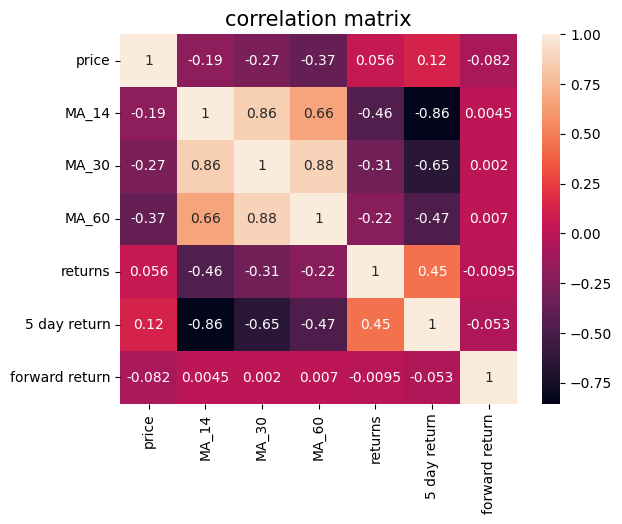

In [55]:
import seaborn as sns
# Plot heatmap of correlation matrix

corr = MA2.corr()
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90) # fix ticklabel directions
plt.title('correlation matrix', fontsize=15)
plt.show()

In [56]:
import statsmodels.api as sm

column_names = MA2.columns
feature_names = column_names.drop('forward return')

train_features = MA2[feature_names]
train_targets = MA2['forward return']

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model
train_predictions = results.predict(train_features)

                                 OLS Regression Results                                
Dep. Variable:         forward return   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              4.331
Date:                Tue, 10 Sep 2024   Prob (F-statistic):                    0.000234
Time:                        15:04:23   Log-Likelihood:                          4826.7
No. Observations:                2905   AIC:                                     -9641.
Df Residuals:                    2899   BIC:                                     -9606.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

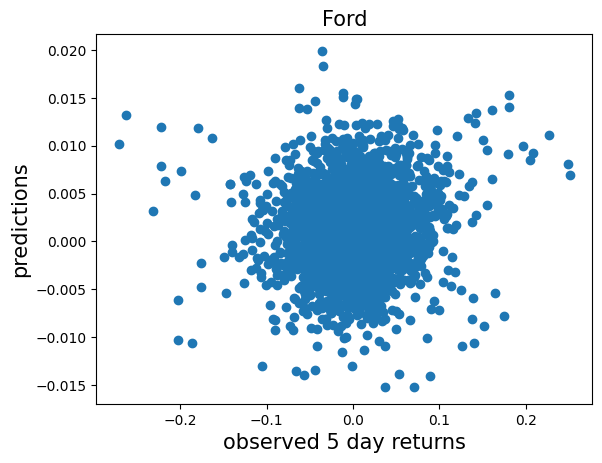

,observed,predictions
observed,1.000000,0.091722
predictions,0.091722,1.000000


In [57]:
predictions_df = pd.DataFrame([train_predictions, train_targets], index=['predictions','observed']).transpose()

plt.scatter( predictions_df['observed'], predictions_df['predictions'])
plt.title('Ford', fontsize=15)
plt.xlabel('observed 5 day returns', fontsize=15)
plt.ylabel('predictions', fontsize=15)
plt.show()
predictions_df[['observed','predictions']].corr()

In [58]:
predictions_df.std()

predictions    0.004250
observed       0.046141
dtype: float64

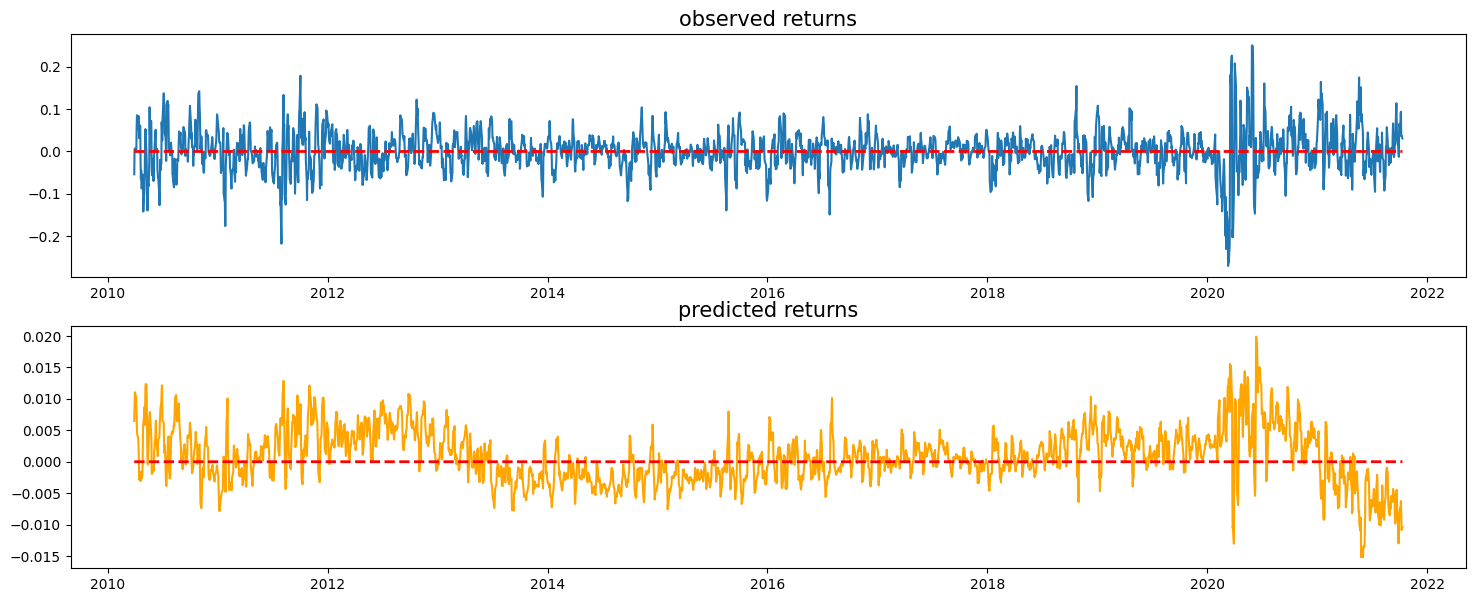

In [59]:
f = plt.figure(figsize=(18,3))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax1.plot(predictions_df['observed'])
ax1.plot(predictions_df.index, [0.0] * predictions_df.shape[0], '--', linewidth=2, color='red')
ax1.set_title('observed returns', fontsize=15)

ax2.plot(predictions_df['predictions'], color='orange')
ax2.plot(predictions_df.index, [0.0] * predictions_df.shape[0], '--', linewidth=2, color='red')
ax2.set_title('predicted returns', fontsize=15)

plt.subplots_adjust(bottom=-.9)
plt.show()

In [60]:
predictions_df['buy and hold'] = predictions_df['observed'].cumsum()
predictions_df.tail()

,predictions,observed,buy and hold
Date,,,
2021-10-05,-0.007043,0.090272,2.729784
2021-10-06,-0.006246,0.093893,2.823677
2021-10-07,-0.008055,0.036919,2.860596
2021-10-08,-0.010867,0.037642,2.898238
2021-10-11,-0.010422,0.030671,2.928909


In [61]:
predictions_df['linear model position'] = [1 if p > 0 else -1 for p in predictions_df['predictions']]
predictions_df.tail()

,predictions,observed,buy and hold,linear model position
Date,,,,
2021-10-05,-0.007043,0.090272,2.729784,-1
2021-10-06,-0.006246,0.093893,2.823677,-1
2021-10-07,-0.008055,0.036919,2.860596,-1
2021-10-08,-0.010867,0.037642,2.898238,-1
2021-10-11,-0.010422,0.030671,2.928909,-1


In [62]:
predictions_df['linear model profit'] = predictions_df['observed'] * predictions_df['linear model position']
predictions_df['linear model'] = predictions_df['linear model profit'].cumsum()
predictions_df.tail()

,predictions,observed,buy and hold,linear model position,linear model profit,linear model
Date,,,,,,
2021-10-05,-0.007043,0.090272,2.729784,-1,-0.090272,10.335992
2021-10-06,-0.006246,0.093893,2.823677,-1,-0.093893,10.242100
2021-10-07,-0.008055,0.036919,2.860596,-1,-0.036919,10.205181
2021-10-08,-0.010867,0.037642,2.898238,-1,-0.037642,10.167538
2021-10-11,-0.010422,0.030671,2.928909,-1,-0.030671,10.136867


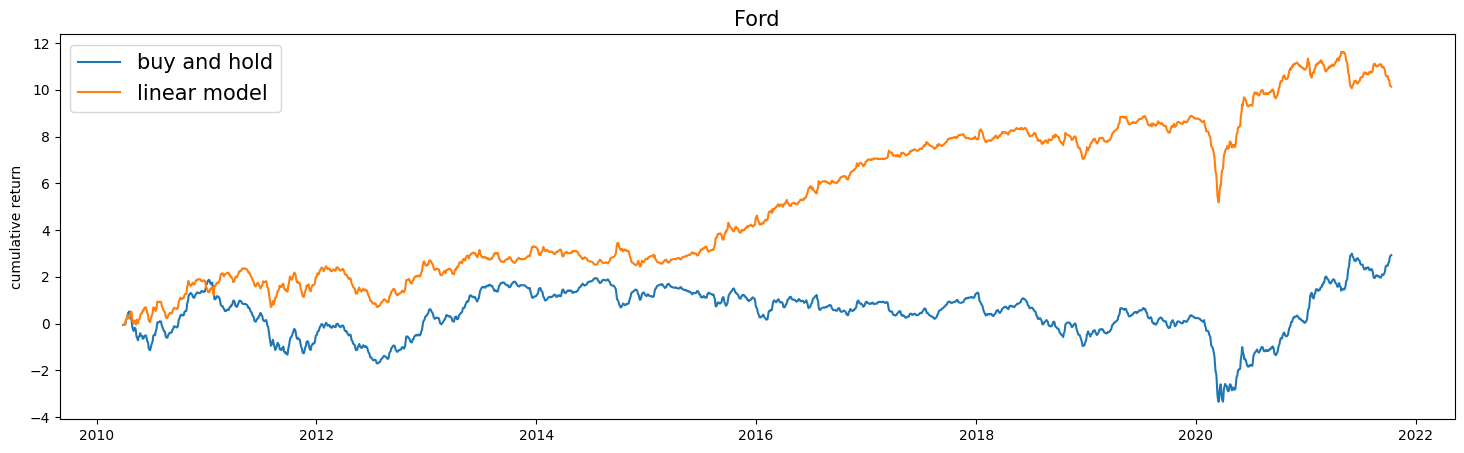

In [63]:
plt.figure(figsize=(18,5))
plt.plot(predictions_df[['buy and hold','linear model']], label=['buy and hold','linear model'])
plt.legend(fontsize=15)
plt.title('Ford',fontsize=15)
plt.ylabel('cumulative return')
plt.show()

In [64]:
predictions_df[['observed','linear model profit']].describe()

,observed,linear model profit
count,2905.000000,2905.000000
mean,0.001008,0.003489
std,0.046141,0.046020
min,-0.270875,-0.270875
25%,-0.023065,-0.020445
50%,0.001162,0.002409
75%,0.024811,0.026988
max,0.251120,0.251120


In [65]:
######################################  run model on test set

In [66]:
MA2test = MA1a[training_set_length:]
print(MA1a.shape,MA2.shape, MA2test.shape)

(3632, 7) (2905, 7) (727, 7)


In [67]:
column_names = MA2.columns
feature_names = column_names.drop('forward return')

test_features = MA2test[feature_names]
test_targets = MA2test['forward return']

# # Create the linear model and complete the least squares fit
# model = sm.OLS(train_targets, train_features)
# results = model.fit()  # fit the model
# print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model
test_predictions = results.predict(test_features)

price           0.000144
MA_14           0.037647
MA_30           0.350564
MA_60           0.897206
returns         0.297321
5 day return    0.035962
dtype: float64


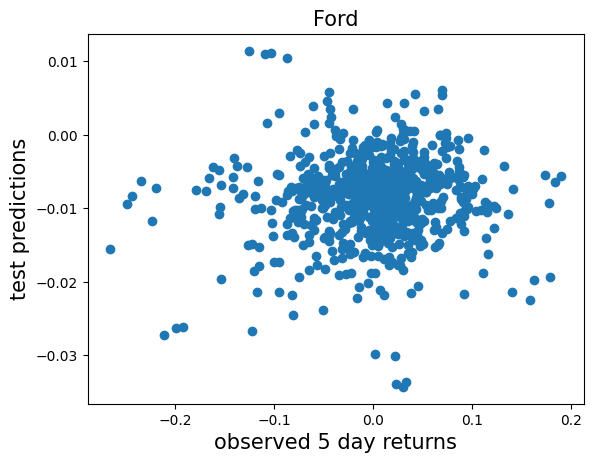

,observed,predictions
observed,1.000000,0.091722
predictions,0.091722,1.000000


In [68]:
test_predictions_df = pd.DataFrame([test_predictions, test_targets], index=['predictions','observed']).transpose()

plt.scatter(test_predictions_df['observed'], test_predictions_df['predictions'])
plt.title('Ford', fontsize=15)
plt.xlabel('observed 5 day returns', fontsize=15)
plt.ylabel('test predictions', fontsize=15)
plt.show()
predictions_df[['observed','predictions']].corr()

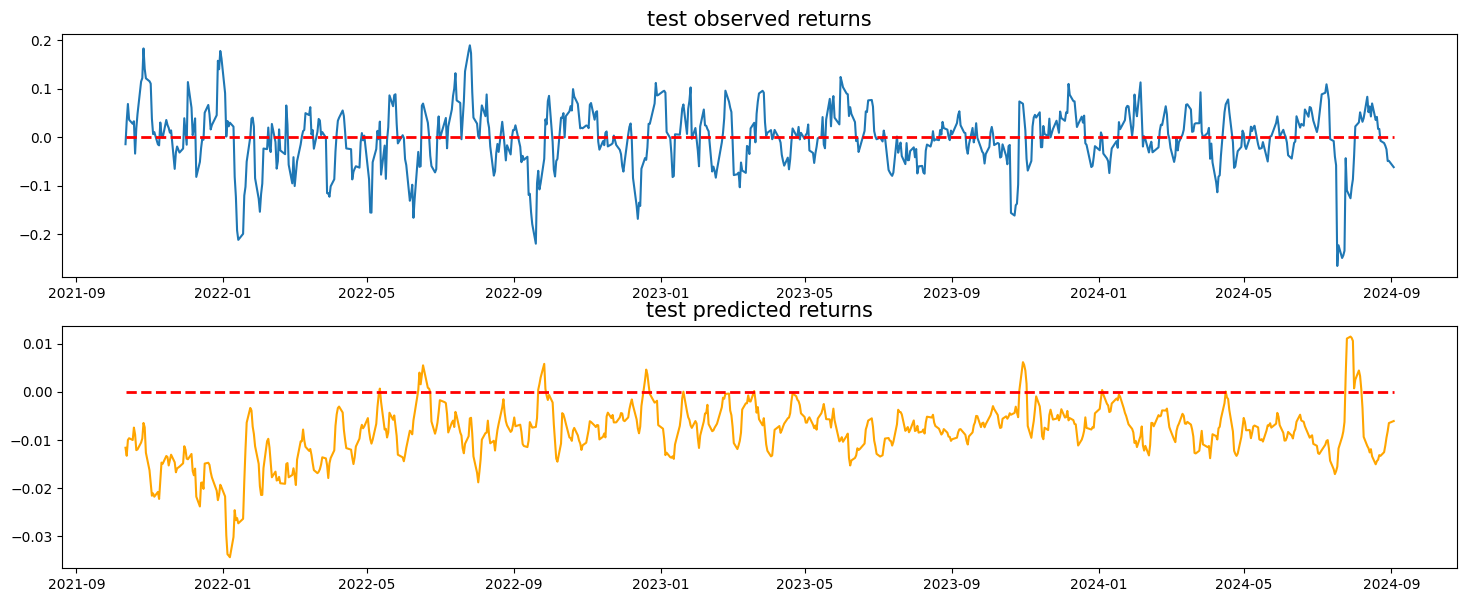

In [69]:
f = plt.figure(figsize=(18,3))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax1.plot(test_predictions_df['observed'])
ax1.plot(test_predictions_df.index, [0.0] * test_predictions_df.shape[0], '--', linewidth=2, color='red')
ax1.set_title('test observed returns', fontsize=15)

ax2.plot(test_predictions_df['predictions'], color='orange')
ax2.plot(test_predictions_df.index, [0.0] * test_predictions_df.shape[0], '--', linewidth=2, color='red')
ax2.set_title('test predicted returns', fontsize=15)

plt.subplots_adjust(bottom=-.9)
plt.show()

In [70]:
test_predictions_df['buy and hold'] = test_predictions_df['observed'].cumsum()
test_predictions_df['linear model position'] = [1 if p > 0 else -1 for p in test_predictions_df['predictions']]
test_predictions_df['linear model profit'] = test_predictions_df['observed'] * test_predictions_df['linear model position']
test_predictions_df['linear model'] = test_predictions_df['linear model profit'].cumsum()
test_predictions_df.tail()

,predictions,observed,buy and hold,linear model position,linear model profit,linear model
Date,,,,,,
2024-08-27,-0.011162,-0.017203,-0.757963,-1,0.017203,0.065475
2024-08-28,-0.009492,-0.024761,-0.782723,-1,0.024761,0.090235
2024-08-29,-0.008182,-0.048880,-0.831603,-1,0.048880,0.139115
2024-08-30,-0.006490,-0.048522,-0.880125,-1,0.048522,0.187638
2024-09-03,-0.006067,-0.061507,-0.941633,-1,0.061507,0.249145


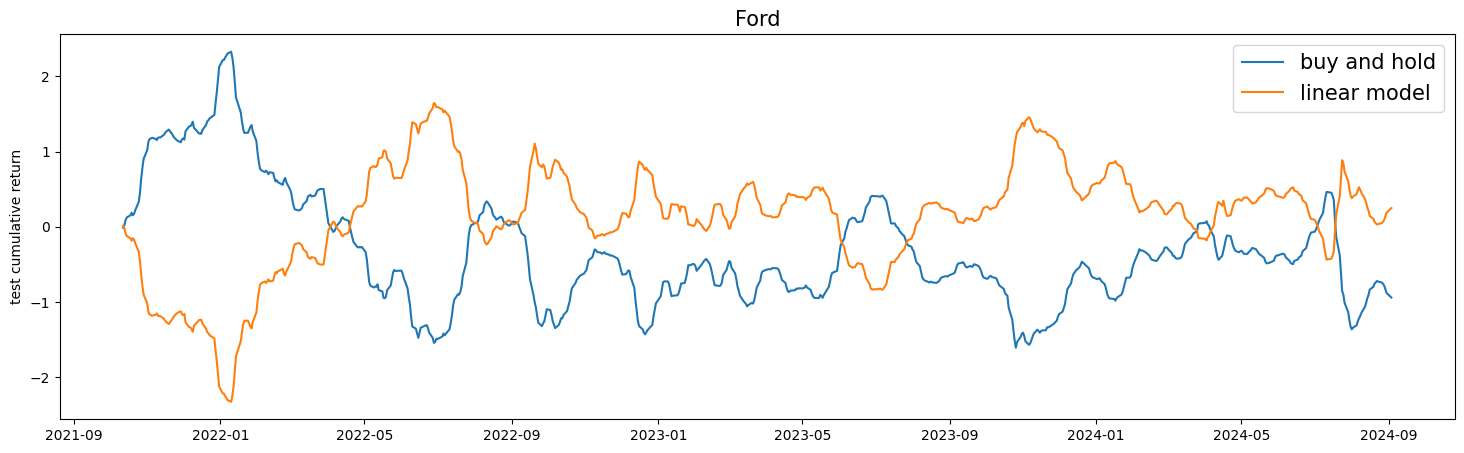

In [71]:
plt.figure(figsize=(18,5))
plt.plot(test_predictions_df[['buy and hold','linear model']], label=['buy and hold','linear model'])
plt.legend(fontsize=15)
plt.title('Ford',fontsize=15)
plt.ylabel('test cumulative return')
plt.show()